In [38]:
# pip install scikit-learn torch ISLP

import warnings
warnings.filterwarnings('ignore')  

import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots

from ISLP import load_data
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim

np.random.seed(42)
torch.manual_seed(42);


## Workflow Overview

In this lab, we address a **regression problem**: predicting Boston house prices. Our workflow consists of:

1. **Data Exploration & Preparation**: Loading the `Boston` dataset and standardizing features using `StandardScaler`.
2. **Model 1 - Simple Linear Regression**: Fitting OLS as a baseline using `LinearRegression`.
3. **Model 2 - Regularized Regression**: Using `RidgeCV` and `LassoCV` with polynomial features to handle overfitting.
4. **Model 3 - Neural Network**: Building a feedforward network in PyTorch to capture non-linear patterns.
5. **Final Comparison**: Comparing all models on test set MSE and R² score.


## The Boston Housing Dataset

We use the `Boston` dataset from the `ISLP` package, the same dataset featured in the ISLR textbook. This dataset contains information about housing in Boston suburbs. The goal is to predict the **median value of owner-occupied homes** (`medv`).

Dataset characteristics:
- **506 observations** (Boston suburbs)
- **12 predictor variables** including:
  - `crim`: Per capita crime rate
  - `rm`: Average number of rooms per dwelling
  - `age`: Proportion of owner-occupied units built prior to 1940
  - `lstat`: Percentage of lower status population
  - `dis`: Weighted distances to employment centers
- **Target variable**: `medv` (median home value in $1000s)

This is a **regression problem** with a continuous target variable, unlike classification where we predict discrete categories.


In [22]:
# Load Boston dataset from ISLP
Boston = load_data('Boston')
print(f"Dataset shape: {Boston.shape}")
Boston.head()


Dataset shape: (506, 13)


,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [23]:
# Separate features (X) and target (y)
X = Boston.drop(columns=['medv'])
y = Boston['medv'].values

# Examine target variable distribution
print(f"Target variable 'medv':")
print(f"  Range: [{y.min():.1f}, {y.max():.1f}] ($1000s)")
print(f"  Mean: {y.mean():.1f}, Std: {y.std():.1f}")


Target variable 'medv':
  Range: [5.0, 50.0] ($1000s)
  Mean: 22.5, Std: 9.2


### Data Preparation

We prepare the data by:
1. **Splitting** into training (80%) and test (20%) sets using `train_test_split()`
2. **Standardizing features** using `StandardScaler()` - this centers data (mean=0) and scales to unit variance (std=1)

Standardization is crucial because:
- Regularization methods (Ridge, Lasso) penalize coefficients equally - features on different scales would be penalized unfairly
- Neural networks converge faster with standardized inputs
- Distance-based methods would be dominated by large-scale features


In [24]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y, test_size=0.2, random_state=42
)

print(f"Training samples: {len(X_train)}")
print(f"Test samples: {len(X_test)}")
print(f"Number of features: {X_train.shape[1]}")


Training samples: 404
Test samples: 102
Number of features: 12


In [25]:
# Standardize features (fit on train, transform both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verify standardization
print("Feature statistics after standardization:")
print(f"  Mean (should be ~0): {X_train_scaled.mean():.6f}")
print(f"  Std (should be ~1):  {X_train_scaled.std():.6f}")


Feature statistics after standardization:
  Mean (should be ~0): 0.000000
  Std (should be ~1):  1.000000


## 1. Simple Linear Regression (OLS)

**Linear Regression** assumes a linear relationship between features and the target:

$$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_p x_p + \epsilon$$

We fit the model by minimizing the **Mean Squared Error (MSE)**:

$$\text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2$$

The `LinearRegression` class from `sklearn` implements **Ordinary Least Squares (OLS)**, which finds the closed-form solution $\hat{\beta} = (X^T X)^{-1} X^T y$.


In [26]:
# Fit simple linear regression
ols = LinearRegression()
ols.fit(X_train_scaled, y_train)

# Make predictions
y_pred_ols = ols.predict(X_test_scaled)

# Evaluate using R² and MSE
print("Simple Linear Regression (OLS):")
print(f"  R² Score: {r2_score(y_test, y_pred_ols):.4f}")
print(f"  MSE:      {mean_squared_error(y_test, y_pred_ols):.2f}")


Simple Linear Regression (OLS):
  R² Score: 0.6894
  MSE:      22.78


In [27]:
# Examine feature coefficients (sorted by magnitude)
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': ols.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("Feature coefficients (sorted by magnitude):")
coef_df


Feature coefficients (sorted by magnitude):


,Feature,Coefficient
11,lstat,-3.819016
7,dis,-3.119459
5,rm,3.004420
4,nox,-2.137599
8,rad,2.058898
10,ptratio,-1.991871
9,tax,-1.871317
0,crim,-1.127473
3,chas,0.787152
1,zn,0.712109


### Regression Metrics

For regression problems, we evaluate models using:

- **MSE (Mean Squared Error)**: Average of squared prediction errors. Lower is better. Computed by `mean_squared_error()`.
- **R² Score**: Proportion of variance explained by the model. Ranges from 0 to 1 (higher is better). Computed by `r2_score()`.

**Key difference from classification**: Unlike classification where we need multiple metrics (Precision, Recall, F1) to capture different aspects of performance, regression typically uses a **single metric** like MSE or R² because predictions are continuous values rather than discrete categories.


## 2. Regularized Regression: Ridge and Lasso

When we have many features (especially with polynomial expansions), OLS can **overfit** the training data. Regularization adds a penalty term to shrink coefficients:

### Ridge Regression (L2 Penalty)
$$\min_{\beta} \sum_{i=1}^n (y_i - X_i'\beta)^2 + \lambda \sum_{j=1}^p \beta_j^2$$

- Shrinks coefficients toward zero but **keeps all features**
- Good when many features contribute small effects

### Lasso Regression (L1 Penalty)
$$\min_{\beta} \sum_{i=1}^n (y_i - X_i'\beta)^2 + \lambda \sum_{j=1}^p |\beta_j|$$

- Can set coefficients **exactly to zero** (automatic feature selection)
- Good when only a few features are truly important

We use `RidgeCV` and `LassoCV` which automatically find the best `alpha` (regularization strength $\lambda$) via cross-validation.


### Creating Polynomial Features

To demonstrate regularization, we expand the feature space using `PolynomialFeatures(degree=2)` which creates:
- All original features
- All squared terms (e.g., `lstat²`)
- All pairwise interactions (e.g., `lstat × rm`)

This creates a much larger feature space where regularization becomes essential to prevent overfitting.


In [28]:
# Create polynomial features (degree=2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

print(f"Original features: {X_train_scaled.shape[1]}")
print(f"Polynomial features: {X_train_poly.shape[1]}")
print(f"\nFeature expansion: {X_train_scaled.shape[1]} → {X_train_poly.shape[1]} features")


Original features: 12
Polynomial features: 90

Feature expansion: 12 → 90 features


In [29]:
# OLS on polynomial features (to demonstrate overfitting)
ols_poly = LinearRegression()
ols_poly.fit(X_train_poly, y_train)

train_r2 = r2_score(y_train, ols_poly.predict(X_train_poly))
test_r2 = r2_score(y_test, ols_poly.predict(X_test_poly))

print("OLS with Polynomial Features (No Regularization):")
print(f"  Training R²: {train_r2:.4f}")
print(f"  Test R²:     {test_r2:.4f}")
print(f"\nNote: The gap between train and test R² ({train_r2 - test_r2:.3f}) indicates overfitting!")


OLS with Polynomial Features (No Regularization):
  Training R²: 0.9341
  Test R²:     0.7933

Note: The gap between train and test R² (0.141) indicates overfitting!


In [30]:
# Ridge regression with cross-validation
alphas = np.logspace(-3, 3, 100)  # Range of alpha values to try
ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train_poly, y_train)

# Predictions
y_pred_ridge = ridge.predict(X_test_poly)

print("Ridge Regression (with Cross-Validation):")
print(f"  Best alpha: {ridge.alpha_:.4f}")
print(f"  R² Score:   {r2_score(y_test, y_pred_ridge):.4f}")
print(f"  MSE:        {mean_squared_error(y_test, y_pred_ridge):.2f}")


Ridge Regression (with Cross-Validation):
  Best alpha: 10.0000
  R² Score:   0.8251
  MSE:        12.83


In [31]:
# Lasso regression with cross-validation
lasso = LassoCV(alphas=alphas, cv=5, max_iter=50000)
lasso.fit(X_train_poly, y_train)

# Predictions
y_pred_lasso = lasso.predict(X_test_poly)

# Count non-zero coefficients (feature selection)
n_nonzero = np.sum(lasso.coef_ != 0)

print("Lasso Regression (with Cross-Validation):")
print(f"  Best alpha: {lasso.alpha_:.4f}")
print(f"  Non-zero coefficients: {n_nonzero}/{len(lasso.coef_)} (automatic feature selection)")
print(f"  R² Score:   {r2_score(y_test, y_pred_lasso):.4f}")
print(f"  MSE:        {mean_squared_error(y_test, y_pred_lasso):.2f}")


Lasso Regression (with Cross-Validation):
  Best alpha: 0.0215
  Non-zero coefficients: 59/90 (automatic feature selection)
  R² Score:   0.8191
  MSE:        13.27


## 3. Neural Network Regression with PyTorch

We now build a **Feedforward Neural Network** for regression. Unlike linear models (even with regularization), neural networks can learn **complex, non-linear patterns** through multiple layers of transformations.

### Architecture
- **Input Layer**: Receives the 12 standardized features
- **Hidden Layers**: Apply non-linear transformations via `ReLU()` activation
- **Output Layer**: Produces the predicted house price (no activation for regression)

### Training Process
1. **Forward Pass**: Compute predictions using `model(X)`
2. **Loss Calculation**: MSE between predictions and targets using `nn.MSELoss()`
3. **Backward Pass**: Compute gradients via `loss.backward()`
4. **Parameter Update**: Adjust weights using `optimizer.step()`


In [32]:
# Convert to PyTorch tensors
X_train_t = torch.FloatTensor(X_train_scaled)
X_test_t = torch.FloatTensor(X_test_scaled)
y_train_t = torch.FloatTensor(y_train).reshape(-1, 1)
y_test_t = torch.FloatTensor(y_test).reshape(-1, 1)

print(f"X_train shape: {X_train_t.shape}")
print(f"y_train shape: {y_train_t.shape}")


X_train shape: torch.Size([404, 12])
y_train shape: torch.Size([404, 1])


In [33]:
# Define the neural network
class RegressionNN(nn.Module):
    """
    Architecture: Input (12) -> Hidden1 (64) -> ReLU -> Hidden2 (32) -> ReLU -> Output (1)
    """
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.net(x)

# Create model
model = RegressionNN(X_train_t.shape[1])
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters())}")


RegressionNN(
  (net): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

Total parameters: 2945


In [34]:
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 200

for epoch in range(num_epochs):
    # Training phase
    model.train()
    y_pred = model(X_train_t)
    loss = criterion(y_pred, y_train_t)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print progress every 50 epochs
    if (epoch + 1) % 50 == 0:
        model.eval()
        with torch.no_grad():
            test_loss = criterion(model(X_test_t), y_test_t)
        print(f"Epoch [{epoch+1}/{num_epochs}] | Train MSE: {loss.item():.2f} | Test MSE: {test_loss.item():.2f}")


Epoch [50/200] | Train MSE: 18.63 | Test MSE: 18.71
Epoch [100/200] | Train MSE: 11.49 | Test MSE: 13.45
Epoch [150/200] | Train MSE: 9.12 | Test MSE: 12.85
Epoch [200/200] | Train MSE: 6.93 | Test MSE: 12.56


In [35]:
# Final evaluation of Neural Network
model.eval()
with torch.no_grad():
    y_pred_nn = model(X_test_t).numpy().flatten()

print("Neural Network:")
print(f"  R² Score: {r2_score(y_test, y_pred_nn):.4f}")
print(f"  MSE:      {mean_squared_error(y_test, y_pred_nn):.2f}")


Neural Network:
  R² Score: 0.8287
  MSE:      12.56


## Model Comparison

Let's compare all models side by side on the test set.


In [36]:
# Create comparison table
results = pd.DataFrame({
    'Model': ['OLS (12 features)', 'Ridge (90 poly features)', 'Lasso (90 poly features)', 'Neural Network (12 features)'],
    'R² Score': [
        r2_score(y_test, y_pred_ols),
        r2_score(y_test, y_pred_ridge),
        r2_score(y_test, y_pred_lasso),
        r2_score(y_test, y_pred_nn)
    ],
    'MSE': [
        mean_squared_error(y_test, y_pred_ols),
        mean_squared_error(y_test, y_pred_ridge),
        mean_squared_error(y_test, y_pred_lasso),
        mean_squared_error(y_test, y_pred_nn)
    ]
}).round(4)

print("=" * 60)
print("FINAL MODEL COMPARISON ON TEST SET")
print("=" * 60)
results


FINAL MODEL COMPARISON ON TEST SET


,Model,R² Score,MSE
0,OLS (12 features),0.6894,22.7777
1,Ridge (90 poly features),0.8251,12.8277
2,Lasso (90 poly features),0.8191,13.2669
3,Neural Network (12 features),0.8287,12.5596


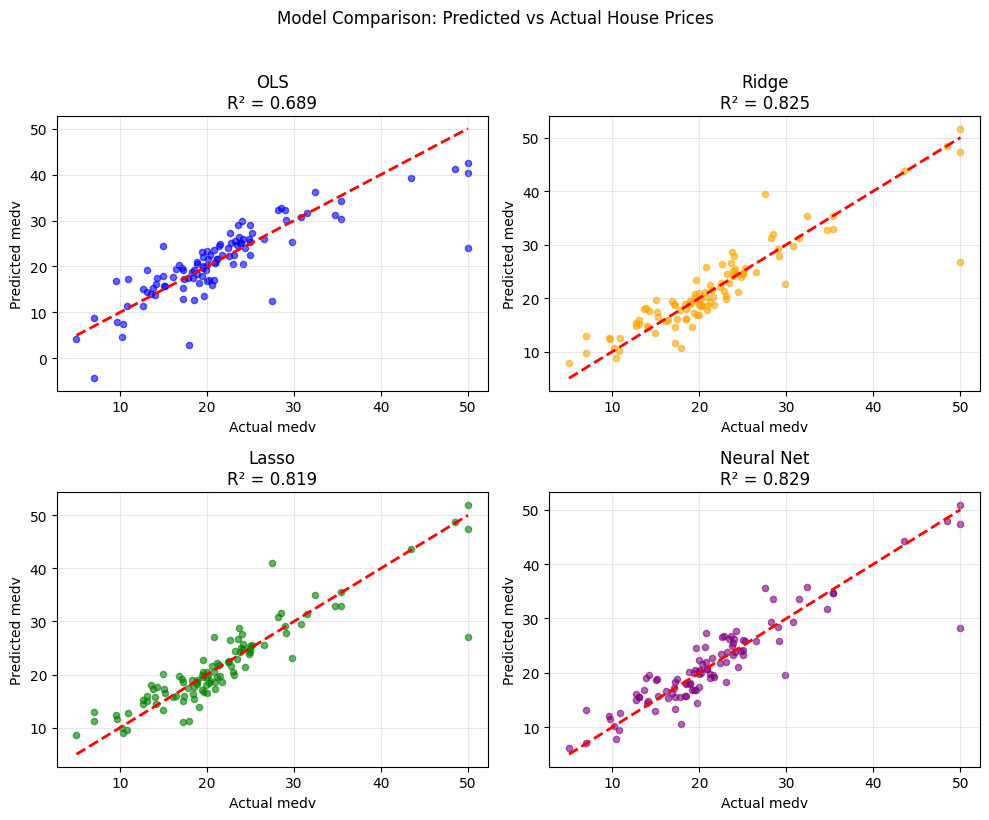

In [37]:
# Visualize predictions vs actual values
fig, axes = subplots(2, 2, figsize=(10, 8))
models = [('OLS', y_pred_ols), ('Ridge', y_pred_ridge), 
          ('Lasso', y_pred_lasso), ('Neural Net', y_pred_nn)]
colors = ['blue', 'orange', 'green', 'purple']

for ax, (name, pred), color in zip(axes.flat, models, colors):
    ax.scatter(y_test, pred, alpha=0.6, c=color, s=20)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    ax.set_xlabel('Actual medv')
    ax.set_ylabel('Predicted medv')
    ax.set_title(f"{name}\nR² = {r2_score(y_test, pred):.3f}")
    ax.grid(alpha=0.3)

fig.suptitle('Model Comparison: Predicted vs Actual House Prices', y=1.02)
fig.tight_layout()


## Summary

We compared four types of models for predicting Boston house prices:

| Model Type | Approach | Key Characteristics |
|------------|----------|---------------------|
| **OLS** | `LinearRegression` with 12 features | Baseline, interpretable, limited capacity |
| **Ridge** | `RidgeCV` with 90 polynomial features | Shrinks coefficients, prevents overfitting |
| **Lasso** | `LassoCV` with 90 polynomial features | Feature selection via L1 penalty |
| **Neural Network** | PyTorch with 2 hidden layers | Learns non-linear patterns automatically |

### Key Takeaways

1. **Feature Engineering Matters**: Polynomial features expand the hypothesis space but can lead to overfitting without regularization.

2. **Regularization Prevents Overfitting**: `Ridge` and `Lasso` reduce the gap between train and test performance by penalizing large coefficients.

3. **Lasso Performs Feature Selection**: The L1 penalty can set coefficients exactly to zero, automatically identifying the most important features.

4. **Neural Networks Are Flexible**: Can learn complex patterns but require more tuning (learning rate, architecture, epochs).

5. **Single Metric for Regression**: Unlike classification, we use MSE or R² to evaluate regression models - no need for multiple metrics like Precision/Recall.
